# Credit Risk Classification

This notebook explores a data set of hypothetical bank customers as well as their payments on various products, recorded in the files `customers.csv` and `payments.csv`, respectively. The goal of this exploration is to build a classifier that can identify whether a customer is a high or low credit risk.

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

## Part 1: Considering only customer data

For this first part, only customer data is considered. Further on, the payment data will be included so that a comparison between both approaches can be drawn and the added value of payment data established.

### Data exploration

The customer data is anonymised, meaning features are not recognizable. This makes heuristic data exploration next to impossible. All that is known is that some of the features are categorical while others are continuous, i.e. numerical:

- Categorical features: `fea_1`, `fea_3`, `fea_5`, `fea_6`, `fea_7`, and `fea_9`
- Continuous variables: `fea_2`, `fea_4`, `fea_8`, `fea_10`, and `fea_11`

Categorical features are assumed to be unordered as there is no further information on them. The column `label` describes whether customers are a high (1) or low credit risk (0)

In [2]:
customers = pd.read_csv(
    "customers.csv",
    dtype=
        {
            "label": "category",
            "fea_1": "category",
            "fea_3": "category",
            "fea_5": "category",
            "fea_6": "category",
            "fea_7": "category",
            "fea_9": "category",
        }
)
customers.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


There are a total of 1125 customers in the dataset, of which 20% are classified as high credit risk.

In [3]:
df = pd.DataFrame(customers.groupby("label").size(), columns=["No. of customers"])
df.loc[:, "Percent of total"] = df / df.sum()
df

,No. of customers,Percent of total
label,,
0,900,0.8
1,225,0.2


#### Feature value distributions

All features appear relatively evenly distributed across both the high and low risk labels.

In [4]:
def plot_feature_distributions(data, num_cols=4, cols_to_exclude=None, hue=None):
    cols_to_exclude = [] if cols_to_exclude is None else cols_to_exclude
    features = [feature for feature in data.columns if feature not in cols_to_exclude]
    num_rows = math.ceil(len(features) / num_cols)
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    for ii, feature in enumerate(features):
        plot_func = sns.countplot if pd.api.types.is_categorical_dtype(data[feature]) else sns.histplot    
        plot_func(data=data, x=feature, hue=hue, ax=ax[ii // num_cols, ii % num_cols])

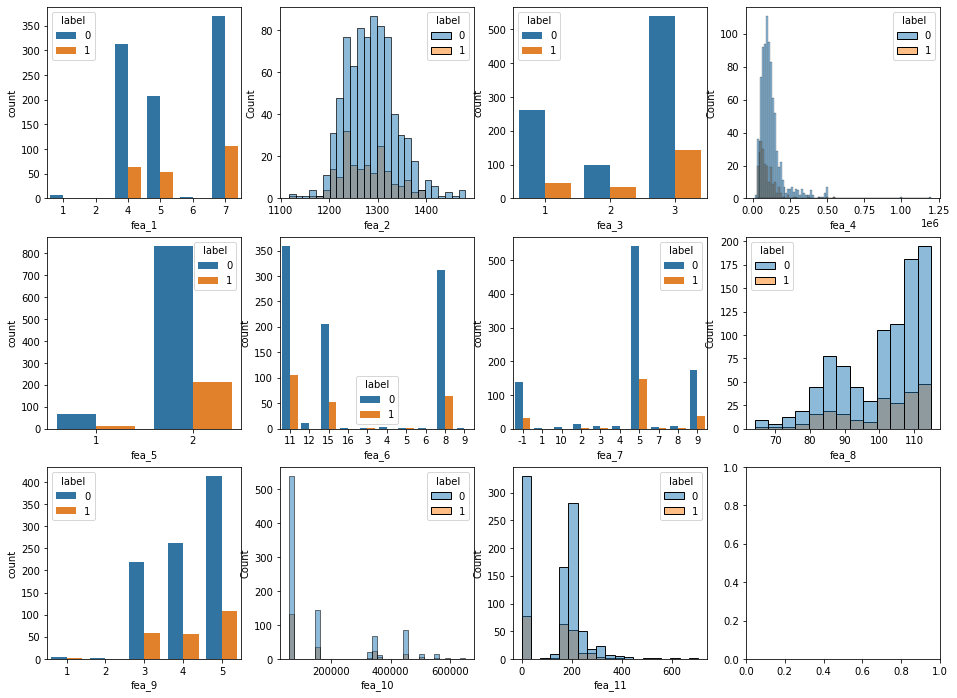

In [5]:
plot_feature_distributions(data=customers, num_cols=4, cols_to_exclude=["id", "label"], hue="label")

#### Missing values

Only `fea_2` exhibits missing values. Approximately `13.2%` of all customers are missing a value for this feature.

In [6]:
df = pd.DataFrame(customers.isnull().sum(), columns=["No. missing values"])
df.loc[:, "Percent of total"] = df / len(customers)
df

,No. missing values,Percent of total
label,0,0.000000
id,0,0.000000
fea_1,0,0.000000
fea_2,149,0.132444
fea_3,0,0.000000
fea_4,0,0.000000
fea_5,0,0.000000
fea_6,0,0.000000
fea_7,0,0.000000
fea_8,0,0.000000


There is a slight preference towards high risk customers missing a value (24% of all customers who are missing values in `fea_2` are high risk versus only 20% of all customers are high risk).

In [7]:
df = pd.DataFrame(
    {
        "Label": customers.loc[:, "label"],
        "No. of customers with missing value in fea_2": customers.loc[:, "fea_2"].isnull(),
    }
).groupby("Label").sum()
df.loc[:, "Percent of total"] = df / df.sum()
df

,No. of customers with missing value in fea_2,Percent of total
Label,,
0,112,0.751678
1,37,0.248322


However, [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) shows that this imbalance is most likely not statistically significant and therefor unlikely to be a predictor for credit risk.

In [8]:
contingency_matrix = np.array(
    [
        [
            ((customers.loc[:, "label"] == "0") & customers.loc[:, "fea_2"].isnull()).sum(),
            ((customers.loc[:, "label"] == "1") & customers.loc[:, "fea_2"].isnull()).sum(),
        ],
        [
            ((customers.loc[:, "label"] == "0") & ~customers.loc[:, "fea_2"].isnull()).sum(),
            ((customers.loc[:, "label"] == "1") & ~customers.loc[:, "fea_2"].isnull()).sum(),
        ],
    ]
)
_, p = fisher_exact(contingency_matrix, alternative="two-sided")
print(f"P-Value of Fisher's exact test: {p:.4f}")

P-Value of Fisher's exact test: 0.1236


Luckily, `fea_2` is a continuous feature, so imputation is easy. Several options are available, including:

- replacing missing values with the mean or median of the remaining values
- determining the generating distribution for `fea_2` and sampling new values from it
- randomly sampling from the remaining values

There are too many missing values for the first option, it would noticeably skew the distribution of values and affect downstream analysis too severely. The second option is excessively complex and requires an estimation of the distribution of `fea_2`, which may introduce errors. The last option is the most suitable, as it allows sampling from the effective distribution without actually knowing it. Note that this may be difficult to bring into production, however. A production environment will most likely not have access to the training data, so the list of possible values from which to sample must be retained as part of the deployed model.

In [9]:
missing_val_customers = customers.loc[customers.loc[:, "fea_2"].isnull(), :]
random_sample = (
    customers
    .loc[~customers.loc[:, "fea_2"].isnull(), "fea_2"]
    .sample(len(missing_val_customers))
    .values
)
customers.loc[customers.loc[:, "fea_2"].isnull(), "fea_2"] = random_sample

### Predictive modeling

As the data contains both categorical and numerical data, a random forest is the most intuitive choice for classification. Alternative approaches, like logistic regression or SVMs, would require that categorical features be split into multiple boolean features, one for each possible value of the original feature. For example, if a categorical feature `fea_X` can take on 3 values, `"0"`, `"1"`, and `"2"`, then it would need to be split into three features, `fea_x_is_1`, `fea_x_is_2`, and `fea_x_is_3`. This would cause the number of features to increase dramatically and make modeling more difficult.

#### Preparing the data

Data is split into a training and test set to tune hyperparameters and assess performance, respectively.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    customers.drop(["label", "id"], axis=1),
    customers.loc[:, "label"].astype(int),
    test_size=0.5,
    stratify=customers.loc[:, "label"].astype(int),
    random_state=42,
)

Non-categorical data columns are normalized to have a median of 0 and a mean absolute deviation of 1. This is more robust than mean and standard deviation and more applicable to non-normally distributed values. Any features for which `mad == 0` will be removed.

The normalization parameters are calculated from only the training set to keep the test set as independent as possible and not bias the model towards this particular data distribution.

In [11]:
medians = X_train.median(numeric_only=True)
mads = X_train.mad()
# This is a sanity check to ensure both median and mad only handle the numeric features since *.mad doesn't provide the numeric_only argument
assert set(medians.index) == set(mads.index)

X_train = X_train.drop(mads[mads == 0].index, axis=1)
X_test = X_test.drop(mads[mads == 0].index, axis=1)

for col in X_train.columns:
    if col not in medians.index:
        continue
    X_train.loc[:, col] -= medians[col]
    X_train.loc[:, col] /= mads[col]
    X_test.loc[:, col] -= medians[col]
    X_test.loc[:, col] /= mads[col]

#### Hyperparameter tuning with cross-validation

There are a number of possible parameters for a random forest classifier.

In [12]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Many of these are interdependent, however. The most impactful (and intuitive) parameters are the number of estimators, the maximum depth, and the maximum number of features considered at each split.

In [13]:
param_grid = {
    "n_estimators": [10, 25, 50, 100],
    "max_depth": [None, 3, 5, 10, 20, 50],
    "max_features": [None, "auto", "sqrt", "log2"]
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 5, 10, 20, 50],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 25, 50, 100]})

#### Train best estimator on entire training data

In [14]:
estimator = grid_search.best_estimator_
estimator.fit(X_train, y_train);

#### Performance evaluation on test set

The classifier does not perform very well, with an AUC of just above random. The customer data alone is clearly not enough to adequately predict credit risk.

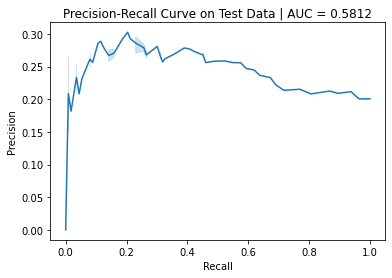

In [18]:
def get_precision_recall(y_pred, y_true):
    results = []
    for _t in np.linspace(0, y_pred.max(), 101):
        tp = np.logical_and(y_pred >= _t, y_true == 1).sum()
        fp = np.logical_and(y_pred >= _t, y_true == 0).sum()
        tn = np.logical_and(y_pred < _t, y_true == 0).sum()
        fn = np.logical_and(y_pred < _t, y_true == 1).sum()
        precision = tp / (tp + fp) if tp > 0 else 0
        recall = tp / (tp + fn) if tp > 0 else 0
        results.append((_t, tp, fp, tn, fn, precision, recall))
    return pd.DataFrame(
        results, 
        columns=[
            "Threshold", 
            "True Positives", 
            "False Positives", 
            "True Negatives", 
            "False Negatives", 
            "Precision", 
            "Recall"
        ]
    )

y_pred_test = estimator.predict_proba(X_test)[:, 1]
pr = get_precision_recall(y_pred_test, y_test)
auc = roc_auc_score(y_true=y_test, y_score=y_pred_test)
sns.lineplot(data=pr, x="Recall", y="Precision").set_title(f"Precision-Recall Curve on Test Data | AUC = {auc:.4f}");

Even on the training data the performance is modest.

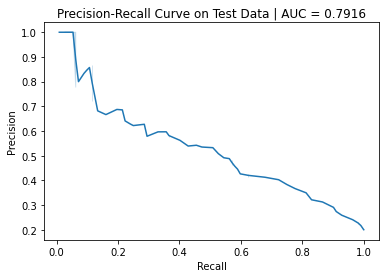

In [16]:
y_pred_train = estimator.predict_proba(X_train)[:, 1]
pr = get_precision_recall(y_pred_train, y_train)
auc = roc_auc_score(y_true=y_train, y_score=y_pred_train)
sns.lineplot(data=pr, x="Recall", y="Precision").set_title(f"Precision-Recall Curve on Test Data | AUC = {auc:.4f}");

## Part 2: Including payment data

The payment data consists of multiple rows per customer with details about each customer's payment history for certain products. The data consists of the following columns:

- `id`: Customer ID
- `OVD_t1`: Number of times payment was overdue (type 1)
- `OVD_t2`: Number of times payment was overdue (type 2)
- `OVD_t3`: Number of times payment was overdue (type 3)
- `OVD_sum`: Total number of overdue days
- `pay_normal`: Number of times normal payment was made
- `prod_code`: Credit product code
- `prod_limit`: Credit limit of the product
- `update_date`: Account update date
- `new_balance`: Current balance of the product
- `highest_balance`: Highest balance in history
- `report_date`: Date of recent payment

More information is not known, e.g. what the different types of overdue payments are or details about credit products. 

In [22]:
payments = pd.read_csv("payments.csv", parse_dates=["update_date", "report_date"])
payments.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,2016-04-12,0.0,NaN,NaT
1,58995151,0,0,0,0,1,5,NaN,2016-04-12,588720.0,491100.0,NaT
2,58997200,0,0,0,0,2,5,NaN,2016-04-12,840000.0,700500.0,2016-04-22
3,54988608,0,0,0,0,3,10,37400.0,2016-03-12,8425.2,7520.0,2016-04-25
4,54987763,0,0,0,0,2,10,NaN,2016-03-12,15147.6,NaN,2016-04-26


### Data exploration

The number of transactions per customers ranges from 1 to more than 50.

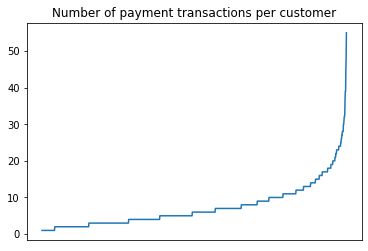

In [23]:
plt.plot(payments.groupby("id").size().sort_values().values);
plt.title("Number of payment transactions per customer");
plt.xlabel("");
plt.gca().axes.xaxis.set_visible(False)

The goal is to generate customer-specific features, since it is customers that should be classified. Barring more complex approaches, like LSTM neural networks that allow for inputs with variable length, the most intuitive approach to engineer these features is to aggregate entries for each customer and generate summary metrics.

The first instinct might be to generate summary statistics for each product individually. However, there is simply not enough data for this kind of approach. A look at the frequency of each product across all customers shows that most products were bought by only a handful of customers. This would result in a very sparse feature matrix as product-specific features would all be missing for customers that did not buy these products.

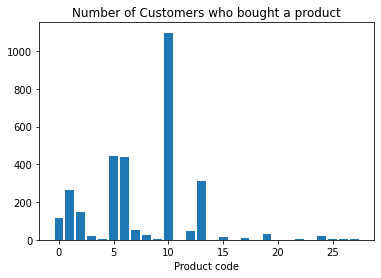

In [59]:
num_customers_with_product = (
    payments
    .groupby(["id", "prod_code"])
    .size()
    .reset_index()
    .drop(0, axis=1)
    .groupby("prod_code")
    .size()
)
plt.bar(x=num_customers_with_product.index, height=num_customers_with_product)
plt.title("Number of Customers who bought a product");
plt.xlabel("Product code");

Instead, features will be aggregated regardless of product code. In order to still retain some information about product diversity, the total number of products as well as the total number of unique products per customer will be considered as features.

#### Missing values

Only a handful of features are missing values.

In [63]:
pd.DataFrame(
    {
        "Missing values": payments.isnull().sum(),
        "Percent of total": payments.isnull().mean(),
    }
)

,Missing values,Percent of total
id,0,0.000000
OVD_t1,0,0.000000
OVD_t2,0,0.000000
OVD_t3,0,0.000000
OVD_sum,0,0.000000
pay_normal,0,0.000000
prod_code,0,0.000000
prod_limit,6118,0.741576
update_date,26,0.003152
new_balance,0,0.000000


Most notable is that `prod_limit` has more values missing than not. This most likely means that these products didn't have a limit. As this is difficult to encode for a machine learning algorithm (there is no numerical equivalent to "no limit"), this feature is best transformed to a boolean flag describing whether the product has a limit or not.

In [65]:
payments.loc[:, "prod_limit"] = payments.loc[:, "prod_limit"].isnull().astype(bool)
payments.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,False,2016-04-12,0.0,NaN,NaT
1,58995151,0,0,0,0,1,5,True,2016-04-12,588720.0,491100.0,NaT
2,58997200,0,0,0,0,2,5,True,2016-04-12,840000.0,700500.0,2016-04-22
3,54988608,0,0,0,0,3,10,False,2016-03-12,8425.2,7520.0,2016-04-25
4,54987763,0,0,0,0,2,10,True,2016-03-12,15147.6,NaN,2016-04-26


The two dates, `report_date` and `update_date`, most likely have little to do with the customer or the payment itself but are records of when payments were processed. Consequently, they will be dropped.

In [73]:
payments = payments.drop(["update_date", "report_date"], axis=1)
payments.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,new_balance,highest_balance
0,58987402,0,0,0,0,1,10,False,0.0,NaN
1,58995151,0,0,0,0,1,5,True,588720.0,491100.0
2,58997200,0,0,0,0,2,5,True,840000.0,700500.0
3,54988608,0,0,0,0,3,10,False,8425.2,7520.0
4,54987763,0,0,0,0,2,10,True,15147.6,NaN


Lastly, missing values in `highest_balance` will be imputed similar to the missing values in the cutomer data, i.e. by randomly sampling from other values for that feature. However, a caveat is that the values for this feature may come from a separate distribution for each product type. Plotting the distributions of this feature for each product types shows notable differences in the scale. This make sense, as different credit products will have different scales, e.g. a mortage will typically be much higher than credit card debts.

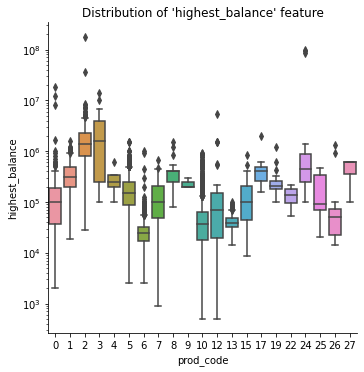

In [74]:
fig = sns.catplot(data=payments, x="prod_code", y="highest_balance", kind="box")
fig.set(yscale="log", title="Distribution of 'highest_balance' feature");

To retain product-specific data distributions, missing values are randomly sampled only from values that correspond to the same product code.

In [75]:
def impute_highest_balance_by_random_sampling(df):
    missing_indices = df.loc[:, "highest_balance"].isnull().values
    random_sample = df.loc[~df.loc[:, "highest_balance"].isnull(), "highest_balance"].sample(missing_indices.sum()).values
    df.loc[missing_indices, "highest_balance"] = random_sample
    return df

payments = payments.groupby("prod_code").apply(impute_highest_balance_by_random_sampling)

#### Feature engineering